In [2]:
import sys 
import joblib
sys.path.append('/home/samuel.varga/python_packages/wofs_ml_severe')
sys.path.append('/home/samuel.varga/python_packages/WoF_post')
sys.path.append('/home/samuel.varga/python_packages/scikit-explain')
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/experiments')
sys.path.append('/home/samuel.varga/python_packages/MontePython/')
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx')
from mlw2w.ml_2to6_data_pipeline import (GridPointExtracter,
                                                       subsampler, 
                                                       load_dataset, random_subsampler)
from os.path import join, exists
import argparse
#Appendages

sys.path.append('/home/samuel.varga/python_packages/ml_workflow/')
sys.path.append('/home/samuel.varga/python_packages/VargaPy/')
# Import packages 
import pandas as pd
import numpy as np
import sklearn
from os.path import join
from sklearn.linear_model import LogisticRegression
from hyperopt import hp
from main.io import load_ml_data
from ml_workflow.calibrated_pipeline_hyperopt_cv import norm_aupdc_scorer, norm_csi_scorer
from ml_workflow.tuned_estimator import TunedEstimator, dates_to_groups
from VargaPy.MlUtils import All_Severe, Drop_Unwanted_Variables, Train_Ml_Parser, group_coefs
from sklearn.model_selection import GroupKFold
import matplotlib.pyplot as plt

lookup_file: /home/samuel.varga/python_packages/WoF_post/wofs/data/psadilookup.dat


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Raw Coefficients
## Load data

In [2]:
%matplotlib inline
FRAMEWORK='POTVIN'
TIMESCALE='2to6'
target_scale='36'
train_scale=None
SigSevere=False
base_path = f'/work/samuel.varga/data/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}'
hazard='all'
X,y,metadata = All_Severe(base_path, mode='train',
                                  target_scale=target_scale,
                                  FRAMEWORK=FRAMEWORK,
                                  TIMESCALE=TIMESCALE, SigSevere=False)
X, ts_suff, var_suff = Drop_Unwanted_Variables(X, original=False, training_scale=train_scale if not None else None, intrastormOnly=False, envOnly=False)

37752
63915
66734
Using new variables- dropping old 90th percentile
(1274972, 174)
all


In [3]:
namedic={'cape_ml':'ML CAPE',
'cin_ml': 'ML CIN',
'comp_dz':'Comp. Refl.',
'hailcast':'HAILCAST',
'low_level_lapse_rate': 'LL Lapse Rate',
'mid_level_lapse_rate': 'ML Lapse Rate',
'okubo_weiss': 'Okubo Weiss',
'scp': 'SCP',
'shear_u_0to1':'0-1 U Shear',
'shear_u_0to6':'0-6 U Shear',
'shear_u_3to6':'3-6 U Shear',
'shear_v_0to1':'0-1 V Shear',
'shear_v_0to6':'0-6 V Shear',
'shear_v_3to6':'3-6 V Shear',
'srh_0to3':'0-3 SRH',
'stp':'STP',
'uh_0to2_instant':'0-2 UH',
'uh_2to5_instant':'2-5 UH',
'w_up':'Max Updraft',
'ws_80':'80m Wind Speed',
'wz_0to2_instant':'0-2 Vert. Vort.',
'Init Time':'Init Time'}
categoryname={'time_avg':'environment', 'time_max':'storm'}

## Plot Coefficient Ranks

In [4]:
from skexplain.common.importance_utils import to_skexplain_importance
import skexplain
model_ind=0
base_path=f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}'
model=joblib.load(join(base_path, f'mlModels/{target_scale}km/Varga_{train_scale+"km" if train_scale is not None else "all"}_logistic_{hazard}_{target_scale}km_control_{model_ind}.joblib'))
#model=joblib.load(join(base_path, f'mlModels/{target_scale+"km"}/Varga_{ts_suff}_logistic_{hazard}_{target_scale+"km"}_{"SigSev" if SigSevere else "Sev"}_{var_suff}_{model_ind}.joblib'))

# X and y are the training dataset
explainer = skexplain.ExplainToolkit(X=X,y=y)
coefs = model['model'].calibrated_classifiers_[0].base_estimator.named_steps['model'].coef_[0,:]

In [5]:
Z=group_coefs(X.columns, coefs)
if '4km' in Z.category.values:
    copy = Z.copy()
    bad_ind=copy.category.values=='4km'
    sub=Z.category.values[bad_ind]
    sub2=Z.neighborhood.values[bad_ind]
    sub3=Z.statistic.values[bad_ind]
    copy.category.values[bad_ind]=sub3
    copy.neighborhood.values[bad_ind]=sub
    copy.statistic.values[bad_ind]=sub2
    Z=copy.copy()
Z=Z.groupby(['neighborhood','category']).sum().reset_index() #variable, category, neighborhood, statistic
Z.sort_values(by='coef', ascending=False)

,neighborhood,category,coef
2,45km,time_avg,12.190850
0,27km,time_avg,8.636842
3,45km,time_max,4.131159
4,9km,time_avg,2.041957
1,27km,time_max,1.394181
5,9km,time_max,1.320650


In [6]:
if 'variable' in Z.columns:
    Z.variable=list(map(namedic.get, Z.variable))
    names=np.array(Z.variable + ' ' + Z.neighborhood)#'_'+Z.neighborhood)
    names=np.array(Z.neighborhood)
if 'category' in Z.columns:
    Z.category=list(map(categoryname.get, Z.category))

names=Z[Z.columns[:-1:]].astype(str).agg(' '.join, axis=1)
coefs_=np.array(Z.coef)

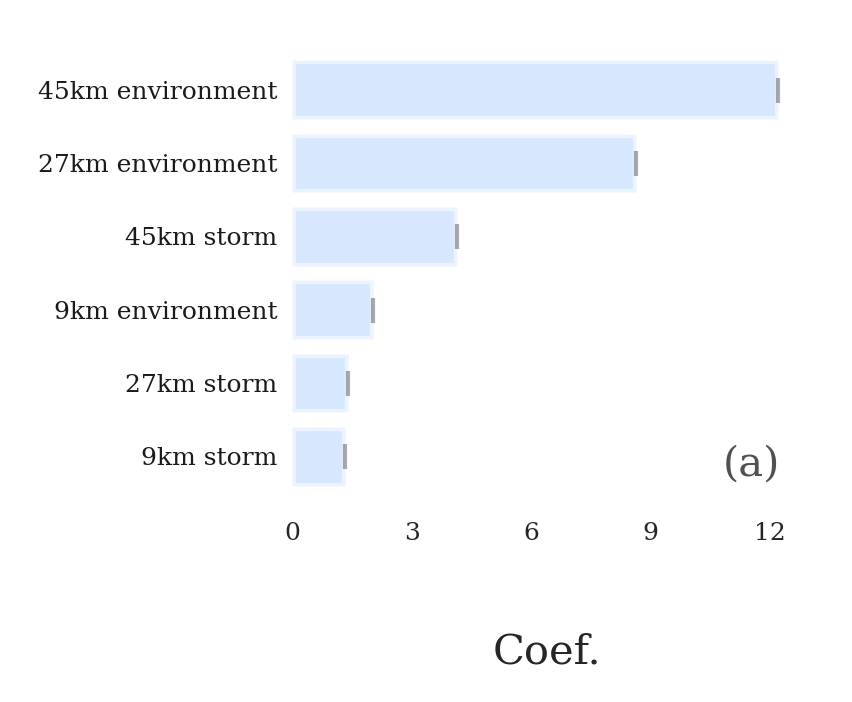

In [7]:
coef_rank = to_skexplain_importance(coefs_,
                                       estimator_name='LogisticRegression', 
                                       feature_names=names, 
                                        method = 'coefs', normalize=False)

panels = [('coefs', 'LogisticRegression')]
fig = explainer.plot_importance(data=coef_rank, panels=panels, 
                                num_vars_to_plot=20, 
                               )

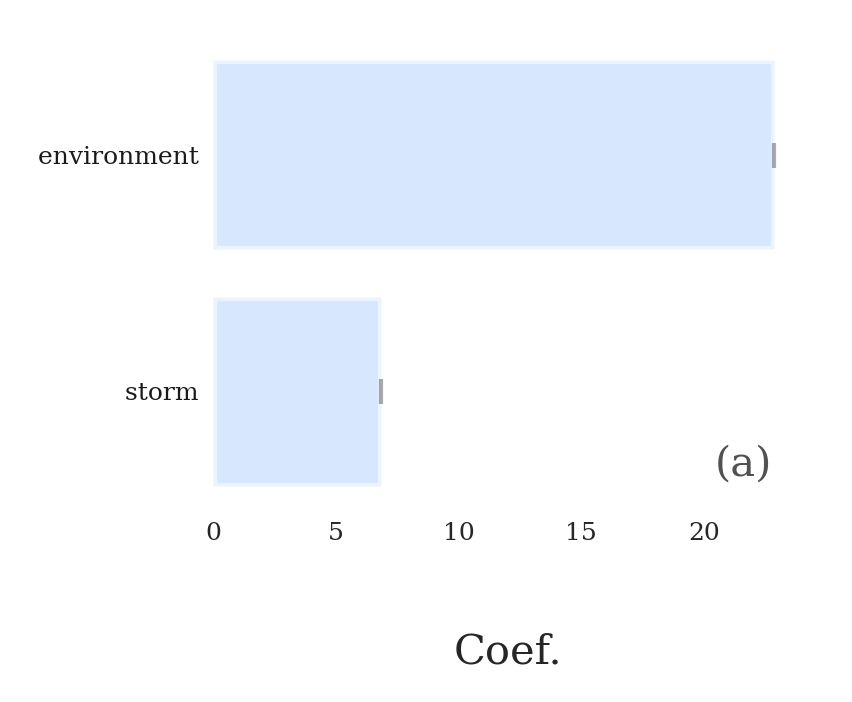

In [8]:
Z=group_coefs(X.columns, coefs)
if '4km' in Z.category.values:
    copy = Z.copy()
    bad_ind=copy.category.values=='4km'
    sub=Z.category.values[bad_ind]
    sub2=Z.neighborhood.values[bad_ind]
    sub3=Z.statistic.values[bad_ind]
    copy.category.values[bad_ind]=sub3
    copy.neighborhood.values[bad_ind]=sub
    copy.statistic.values[bad_ind]=sub2
    Z=copy.copy()
Z=Z.groupby(['category']).sum().reset_index() #variable, category, neighborhood, statistic
#Z.sort_values(by='coef', ascending=False)
if 'variable' in Z.columns:
    Z.variable=list(map(namedic.get, Z.variable))
    names=np.array(Z.variable + ' ' + Z.neighborhood)#'_'+Z.neighborhood)
    names=np.array(Z.neighborhood)
if 'category' in Z.columns:
    Z.category=list(map(categoryname.get, Z.category))

names=Z[Z.columns[:-1:]].astype(str).agg(' '.join, axis=1)
coefs_=np.array(Z.coef)
coef_rank = to_skexplain_importance(coefs_,
                                       estimator_name='LogisticRegression', 
                                       feature_names=names, 
                                        method = 'coefs', normalize=False)

panels = [('coefs', 'LogisticRegression')]
fig = explainer.plot_importance(data=coef_rank, panels=panels, 
                                num_vars_to_plot=20, 
                               )

(0.0, 2.3)

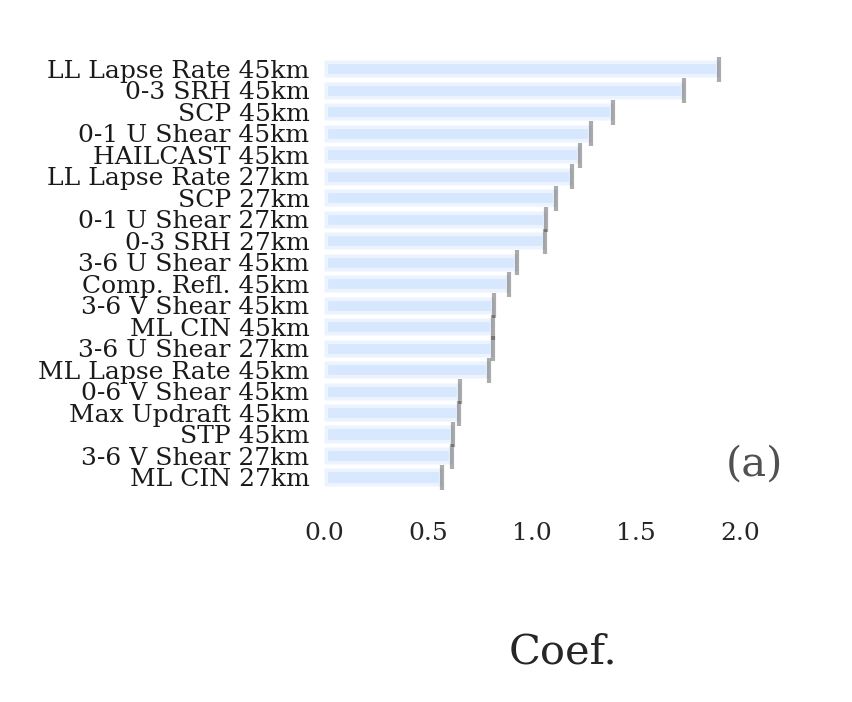

In [9]:
Z=group_coefs(X.columns, coefs)
if '4km' in Z.category.values:
    copy = Z.copy()
    bad_ind=copy.category.values=='4km'
    sub=Z.category.values[bad_ind]
    sub2=Z.neighborhood.values[bad_ind]
    sub3=Z.statistic.values[bad_ind]
    copy.category.values[bad_ind]=sub3
    copy.neighborhood.values[bad_ind]=sub
    copy.statistic.values[bad_ind]=sub2
    Z=copy.copy()
Z=Z.groupby(['variable','neighborhood']).sum().reset_index() #variable, category, neighborhood, statistic
#Z.sort_values(by='coef', ascending=False)
if 'variable' in Z.columns:
    Z.variable=list(map(namedic.get, Z.variable))
    names=np.array(Z.variable + ' ' + Z.neighborhood)#'_'+Z.neighborhood)
    names=np.array(Z.neighborhood)
if 'category' in Z.columns:
    Z.category=list(map(categoryname.get, Z.category))

names=Z[Z.columns[:-1:]].astype(str).agg(' '.join, axis=1)
coefs_=np.array(Z.coef)
coef_rank = to_skexplain_importance(coefs_,
                                       estimator_name='LogisticRegression', 
                                       feature_names=names, 
                                        method = 'coefs', normalize=False)

panels = [('coefs', 'LogisticRegression')]
fig = explainer.plot_importance(data=coef_rank, panels=panels, 
                                num_vars_to_plot=20, 
                               )
fig[1].set_xlim(0,2.3)

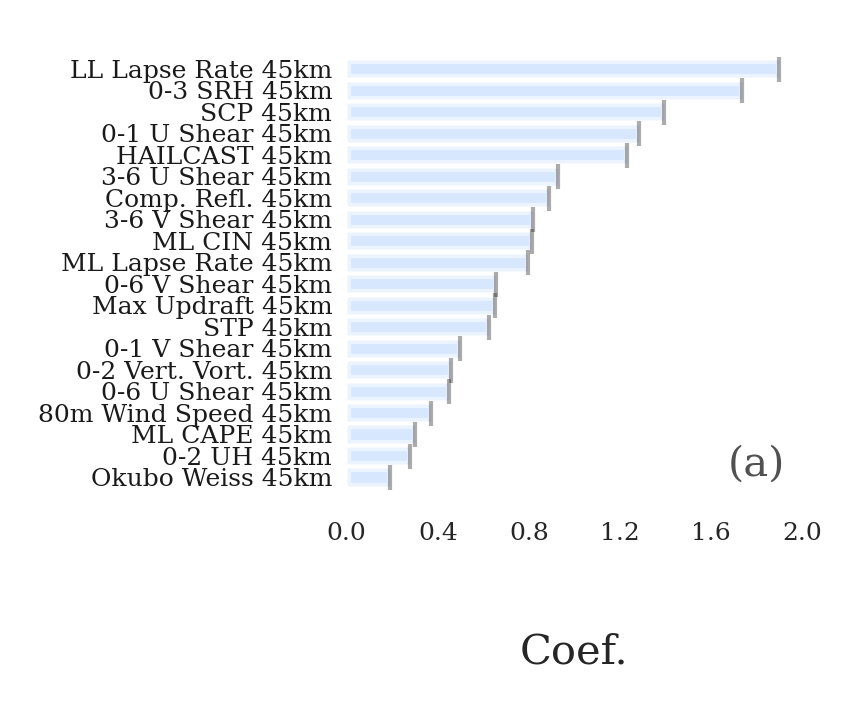

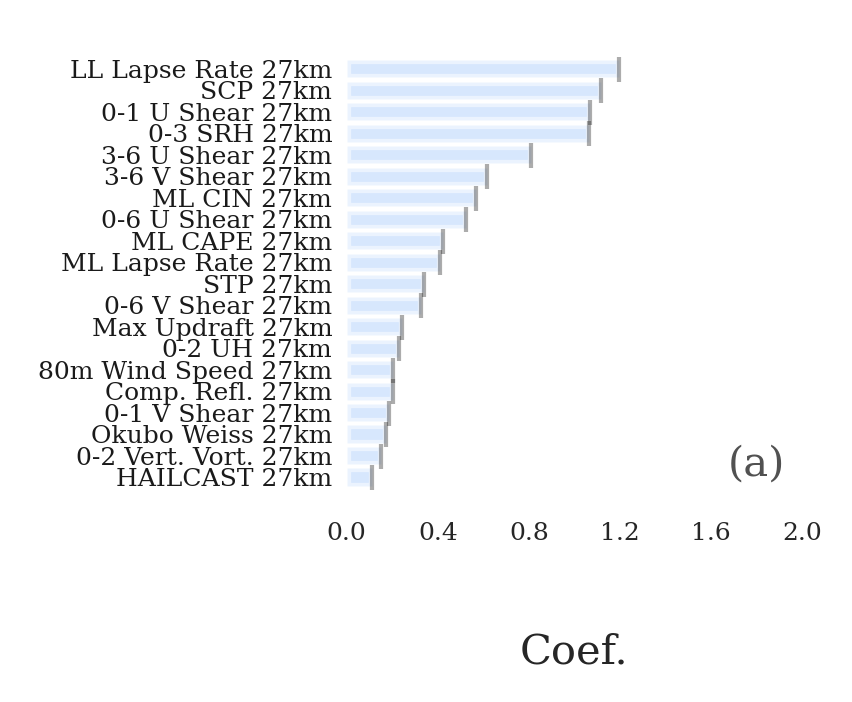

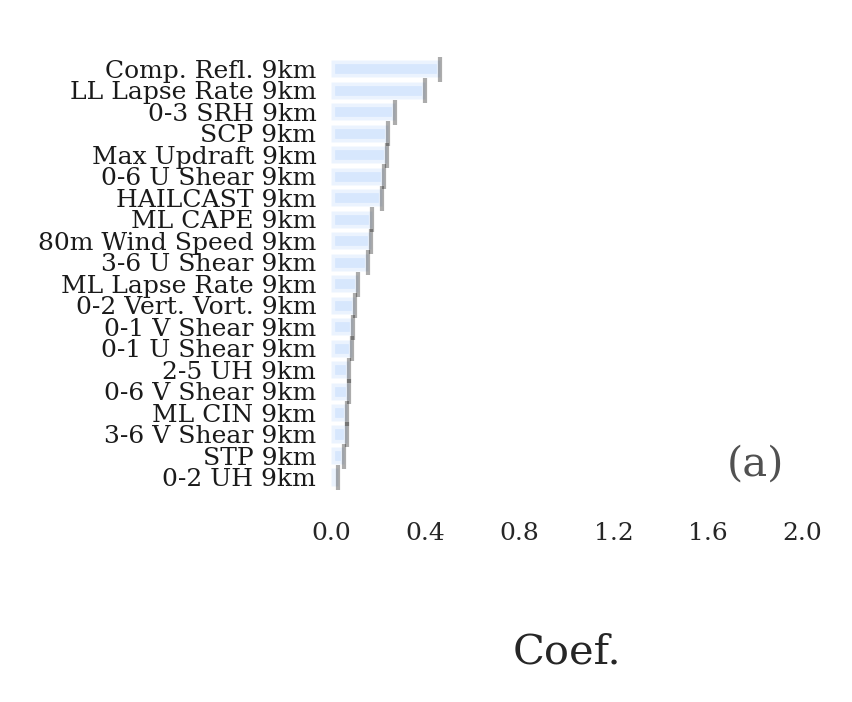

In [10]:
Z=group_coefs(X.columns, coefs)
Z=Z.groupby(['variable','neighborhood']).sum().reset_index() #variable, category, neighborhood, statistic
#Z.sort_values(by='coef', ascending=False)
if 'variable' in Z.columns:
    Z.variable=list(map(namedic.get, Z.variable))
    names=np.array(Z.variable + ' ' + Z.neighborhood)#'_'+Z.neighborhood)
    names=np.array(Z.neighborhood)
if 'category' in Z.columns:
    Z.category=list(map(categoryname.get, Z.category))

names=Z[Z.columns[:-1:]].astype(str).agg(' '.join, axis=1)
coefs_=np.array(Z.coef)
for t_scale in ['45','27','9']:
    coef_rank = to_skexplain_importance(coefs_[Z.neighborhood==f'{t_scale}km'],
                                           estimator_name='LogisticRegression', 
                                           feature_names=names[Z.neighborhood==f'{t_scale}km'], 
                                            method = 'coefs', normalize=False)

    panels = [('coefs', 'LogisticRegression')]
    fig = explainer.plot_importance(data=coef_rank, panels=panels, 
                                    num_vars_to_plot=20, 
                                   )
    fig[1].set_xlim(0,2)
    plt.show()

# Scaled Inputs * Coefficients

Clearly, the coefficients are on different scales. We now take a random sample of the standardized data from the training dataset, and compute the product of the coefficient * scaled data. If these remain on different scales, then we cannot compare the coefficients effectively. Monte's suggestion: the intrastorm vars are heavily skewed to the right, instead of Gaussian. As such, the mean is larger than the mode. The LR may learn smaller coefficients due to the mean being so high compared to the majority of the data.

In [15]:
#Code generously provided by Monte:
def just_transforms(model, X):
    '''Applies all transforms to the data, without applying last estimator
    
    Parameters
    ----------
    X: iterable
        Data to predict on. Must fulfill input requirements of first step of the pipeline'''
    
    #X=fix_data(X) #Not sure what this is supposed to do, ask M
    
    Xt=X
    
    for name, transform in model.steps[:-1]:
        Xt=transform.transform(Xt)
    return Xt

def lr_inputs(model, X):
    '''Compute the product of the model coefficients and processed inputs (e.g. scaling)'''
    #Scale the input
    try:
        base_est=model.estimators[0].calibrated_classifiers_[0].base_estimator
    except:
        base_est = model['model'].calibrated_classifiers_[0].base_estimator
    Xt = just_transforms(base_est, X)
    coef = base_est.named_steps['model'].coef_[0,:]
    
    inputs=coef*Xt
    return inputs

def get_top_features(inputs,X,features,ind):
    '''Using the LR coefficients, determine the top 5 predictors and their values'''
    '''params: 
        inputs: array. List/array of scaled input * coefficient
        X: full sized training dataset
        features: Name of columns in X
        ind: indices to randomly subsample'''
    #Get the absolute values. The onehotencoding on hte initialization time adds additional features.
    #To bypass that issue, we only include non init time features.
    
    abs_inputs = np.absolute(inputs[:])
    #Sort the values and get the highest values
    sorted_indices = np.argsort(abs_inputs)[::-1]
    
    top_features = np.array(features)[sorted_indices][:5] #Put the feature list into an array, resort them, and take the top 5 features for each data point
    #Should return len(X) x 5
    
    top_values = X[top_features].values[ind] #Get top 5 features and values at each point, then  draw a subsample
    #Should return n_samples x 5
    #This isn't sampling the same features at each point, so how does it help?
    
    return top_features, top_values

In [16]:
inputs = lr_inputs(model, X)#Get coefficients*scaled input
abs_inputs = np.abs(inputs)
#pd.DataFrame(data=abs_inputs, columns=X.columns).loc[np.random.choice(np.arange(0,len(X)), 100000, replace=False)].hist(figsize=((10,10)))
#top_f, top_v = get_top_features(inputs, X, X.columns, np.random.choice(np.arange(0,len(X)),100000))


In [71]:
#Randomly Sample 100,000 Points and get the abs(coefficient*predictor) for each predictor
#f=pd.DataFrame(data=abs_inputs, columns=X.columns).loc[np.random.choice(np.arange(0,len(X)), 100000, replace=False)]
f=pd.DataFrame(data=inputs, columns=X.columns).loc[np.random.choice(np.arange(0,len(X)), 100000, replace=False)]
f.head()

,uh_2to5_instant__time_max__45km__ens_mean,uh_0to2_instant__time_max__45km__ens_mean,wz_0to2_instant__time_max__45km__ens_mean,comp_dz__time_max__45km__ens_mean,ws_80__time_max__45km__ens_mean,hailcast__time_max__45km__ens_mean,w_up__time_max__45km__ens_mean,okubo_weiss__time_max__45km__ens_mean,uh_2to5_instant__time_max__45km__ens_2nd,uh_0to2_instant__time_max__45km__ens_2nd,...,shear_v_0to1__time_avg__9km__ens_std,shear_u_0to6__time_avg__9km__ens_std,shear_v_0to6__time_avg__9km__ens_std,shear_u_3to6__time_avg__9km__ens_std,shear_v_3to6__time_avg__9km__ens_std,srh_0to3__time_avg__9km__ens_std,cape_ml__time_avg__9km__ens_std,cin_ml__time_avg__9km__ens_std,stp__time_avg__9km__ens_std,scp__time_avg__9km__ens_std
482317,0.042651,-0.274603,0.529550,0.470895,0.304684,1.740316,-1.270179,-0.095488,0.006531,0.004754,...,-0.046517,-0.095499,-0.016922,0.003049,-0.002026,-0.002850,0.039672,0.010070,0.020513,0.360480
861937,-0.016786,0.115835,-0.177199,0.219844,-0.049920,-0.300757,0.318879,0.048443,-0.004759,-0.003225,...,0.065948,0.059160,0.031005,-0.016229,-0.045525,0.010166,-0.019607,-0.017538,-0.004997,-0.112306
387564,0.017915,0.048487,-0.030442,0.074663,0.088697,0.528214,-0.621589,-0.025249,-0.004997,-0.004513,...,0.043447,-0.003413,-0.004545,-0.016089,-0.017397,-0.000231,0.085555,0.012737,0.004890,0.055033
793079,-0.015695,0.113703,-0.169418,-0.131419,-0.021651,-0.300757,0.339425,0.044494,-0.004365,-0.003654,...,0.026428,0.028069,0.012186,-0.019661,-0.020122,-0.000908,-0.011380,0.016963,-0.004784,-0.040124
619454,0.021036,-0.100884,0.324690,0.317557,0.177081,1.036077,-0.767055,-0.072327,-0.004980,-0.003189,...,-0.018423,-0.068735,-0.031458,-0.003226,0.011293,-0.006683,0.043128,0.028162,-0.004941,-0.063004


In [72]:
#Creates a second dataframe that breaks every column into the variable, category, neighborhood, and statistic
ref_frame=group_coefs(X.columns,coefs).set_index(X.columns).drop('coef', axis=1).T
ref_frame.head()

,uh_2to5_instant__time_max__45km__ens_mean,uh_0to2_instant__time_max__45km__ens_mean,wz_0to2_instant__time_max__45km__ens_mean,comp_dz__time_max__45km__ens_mean,ws_80__time_max__45km__ens_mean,hailcast__time_max__45km__ens_mean,w_up__time_max__45km__ens_mean,okubo_weiss__time_max__45km__ens_mean,uh_2to5_instant__time_max__45km__ens_2nd,uh_0to2_instant__time_max__45km__ens_2nd,...,shear_v_0to1__time_avg__9km__ens_std,shear_u_0to6__time_avg__9km__ens_std,shear_v_0to6__time_avg__9km__ens_std,shear_u_3to6__time_avg__9km__ens_std,shear_v_3to6__time_avg__9km__ens_std,srh_0to3__time_avg__9km__ens_std,cape_ml__time_avg__9km__ens_std,cin_ml__time_avg__9km__ens_std,stp__time_avg__9km__ens_std,scp__time_avg__9km__ens_std
variable,uh_2to5_instant,uh_0to2_instant,wz_0to2_instant,comp_dz,ws_80,hailcast,w_up,okubo_weiss,uh_2to5_instant,uh_0to2_instant,...,shear_v_0to1,shear_u_0to6,shear_v_0to6,shear_u_3to6,shear_v_3to6,srh_0to3,cape_ml,cin_ml,stp,scp
category,time_max,time_max,time_max,time_max,time_max,time_max,time_max,time_max,time_max,time_max,...,time_avg,time_avg,time_avg,time_avg,time_avg,time_avg,time_avg,time_avg,time_avg,time_avg
neighborhood,45km,45km,45km,45km,45km,45km,45km,45km,45km,45km,...,9km,9km,9km,9km,9km,9km,9km,9km,9km,9km
statistic,ens_mean,ens_mean,ens_mean,ens_mean,ens_mean,ens_mean,ens_mean,ens_mean,ens_2nd,ens_2nd,...,ens_std,ens_std,ens_std,ens_std,ens_std,ens_std,ens_std,ens_std,ens_std,ens_std


In [73]:
stack_df=f.T #Transpose the columns, so that they are the index
#Use the reference frame to break each column into its components, then create a multiindex from those components
#Finally, rotate the frame back to the original rotation
stack_df.index=pd.MultiIndex.from_tuples([ref_frame[X] for X in f.columns])
stack_df=stack_df.T
stack_df.head()

,uh_2to5_instant,uh_0to2_instant,wz_0to2_instant,comp_dz,ws_80,hailcast,w_up,okubo_weiss,uh_2to5_instant,uh_0to2_instant,...,shear_v_0to1,shear_u_0to6,shear_v_0to6,shear_u_3to6,shear_v_3to6,srh_0to3,cape_ml,cin_ml,stp,scp
,time_max,time_max,time_max,time_max,time_max,time_max,time_max,time_max,time_max,time_max,...,time_avg,time_avg,time_avg,time_avg,time_avg,time_avg,time_avg,time_avg,time_avg,time_avg
,45km,45km,45km,45km,45km,45km,45km,45km,45km,45km,...,9km,9km,9km,9km,9km,9km,9km,9km,9km,9km
,ens_mean,ens_mean,ens_mean,ens_mean,ens_mean,ens_mean,ens_mean,ens_mean,ens_2nd,ens_2nd,...,ens_std,ens_std,ens_std,ens_std,ens_std,ens_std,ens_std,ens_std,ens_std,ens_std
482317,0.042651,-0.274603,0.529550,0.470895,0.304684,1.740316,-1.270179,-0.095488,0.006531,0.004754,...,-0.046517,-0.095499,-0.016922,0.003049,-0.002026,-0.002850,0.039672,0.010070,0.020513,0.360480
861937,-0.016786,0.115835,-0.177199,0.219844,-0.049920,-0.300757,0.318879,0.048443,-0.004759,-0.003225,...,0.065948,0.059160,0.031005,-0.016229,-0.045525,0.010166,-0.019607,-0.017538,-0.004997,-0.112306
387564,0.017915,0.048487,-0.030442,0.074663,0.088697,0.528214,-0.621589,-0.025249,-0.004997,-0.004513,...,0.043447,-0.003413,-0.004545,-0.016089,-0.017397,-0.000231,0.085555,0.012737,0.004890,0.055033
793079,-0.015695,0.113703,-0.169418,-0.131419,-0.021651,-0.300757,0.339425,0.044494,-0.004365,-0.003654,...,0.026428,0.028069,0.012186,-0.019661,-0.020122,-0.000908,-0.011380,0.016963,-0.004784,-0.040124
619454,0.021036,-0.100884,0.324690,0.317557,0.177081,1.036077,-0.767055,-0.072327,-0.004980,-0.003189,...,-0.018423,-0.068735,-0.031458,-0.003226,0.011293,-0.006683,0.043128,0.028162,-0.004941,-0.063004


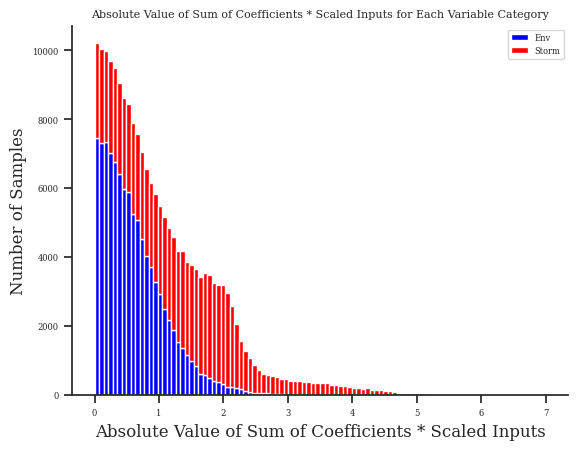

In [86]:
stack_df.groupby(axis=1, level=[1]).sum()#['time_avg'].hist()
#Axis 0: variable; 1: category; 2: Spatial Scale; 3: statistic type

fig, ax =plt.subplots()
ax.hist([np.abs(stack_df.groupby(axis=1, level=[1]).sum()['time_avg']),np.abs(stack_df.groupby(axis=1, level=[1]).sum()['time_max'])], color=['blue','red'], label=['Env','Storm'], bins=100, stacked=True)
#ax.hist(stack_df.groupby(axis=1, level=[1]).sum()['time_max'], color='red', label='Storm', bins=100)
ax.set_title('Absolute Value of Sum of Coefficients * Scaled Inputs for Each Variable Category')
ax.set_ylabel('Number of Samples')
ax.set_xlabel('Absolute Value of Sum of Coefficients * Scaled Inputs')
plt.legend()
plt.show()

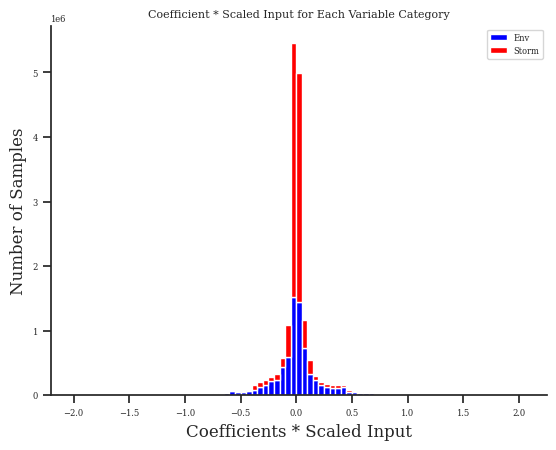

In [82]:
groups=stack_df.groupby(axis=1, level=[1]).groups #Gives dic {'time_avg':[column names]}
#print(len(groups['time_avg']))
#print(pd.DataFrame(stack_df[groups['time_avg']].values.flatten()).describe())
fig, ax =plt.subplots()
bins=np.arange(-2,2.1,.05)
ax.hist([stack_df[groups['time_avg']].values.flatten(), stack_df[groups['time_max']].values.flatten()], bins=bins, color=['blue','red'], label=['Env','Storm'], stacked=True)
#ax.hist(stack_df[groups['time_max']].values.flatten(), bins=bins, color='red', label='Storm')
#ax.set_xlim(-1,2)
ax.set_title('Coefficient * Scaled Input for Each Variable Category')
ax.set_ylabel('Number of Samples')
ax.set_xlabel('Coefficients * Scaled Input')
plt.legend()
plt.show()

96
                  0
count  9.600000e+06
mean   4.429240e-05
std    1.380963e-01
min   -3.002669e+00
25%   -1.348501e-02
50%   -3.403622e-04
75%    1.391411e-02
max    3.375764e+00


(array([2.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 1.000000e+00, 0.000000e+00, 1.000000e+00,
        8.000000e+00, 8.000000e+00, 2.000000e+01, 3.600000e+01,
        4.800000e+01, 7.700000e+01, 7.000000e+01, 1.090000e+02,
        1.130000e+02, 1.290000e+02, 1.560000e+02, 1.760000e+02,
        2.250000e+02, 2.540000e+02, 3.060000e+02, 3.830000e+02,
        5.140000e+02, 5.780000e+02, 7.170000e+02, 8.090000e+02,
        9.000000e+02, 1.016000e+03, 1.135000e+03, 1.230000e+03,
        1.335000e+03, 1.466000e+03, 1.706000e+03, 1.008100e+04,
        3.903000e+03, 5.321000e+03, 6.813000e+03, 1.582800e+04,
        8.363900e+04, 3.014200e+04, 1.338620e+05, 8.078000e+04,
        1.184250e+05, 3.980090e+05, 2.746958e+06, 5.132176e+06,
        3.620050e+05, 1.606040e+05, 5.500800e+04, 4.779200e+04,
        5.070200e+04, 4.697800e+04, 2.198900e+04, 1.519300e+04,
        1.376000e+04, 7.629000e+03, 5.167000e+03, 3.916000e+03,
        3.028000e+03, 2.474000e+03, 2.25

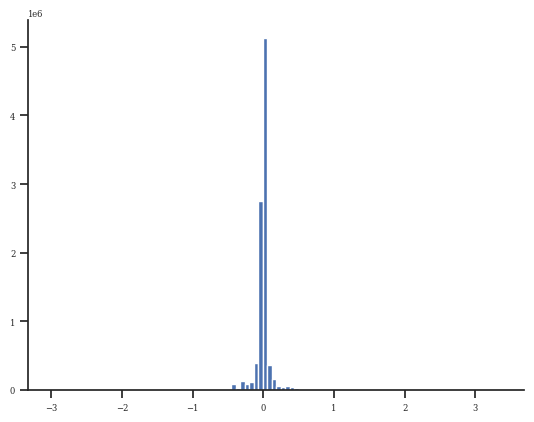

In [38]:
print(len(groups['time_max']))
print(pd.DataFrame(stack_df[groups['time_max']].values.flatten()).describe())
plt.hist(stack_df[groups['time_max']].values.flatten(), bins=100)

In [16]:
base_path=f'/work/samuel.varga/projects/2to6_hr_severe_wx/sfe_prep/mlModels'
out_path = f'/work/samuel.varga/projects/2to6_hr_severe_wx/sfe_prep/stripped_models'

In [18]:
ml_name = f'sfe_all_hist_all_36km_Sev_control_0.joblib'
ml_data=joblib.load(join(base_path, ml_name))['model']

In [25]:
ml_data.base_estimator.named_steps['model'].get_params()

{'categorical_features': None,
 'early_stopping': 'auto',
 'l2_regularization': 0.01,
 'learning_rate': 0.1,
 'loss': 'auto',
 'max_bins': 63,
 'max_depth': 6,
 'max_iter': 100,
 'max_leaf_nodes': 5,
 'min_samples_leaf': 10,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': 42,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}